# Performance plots

John Curtin & Coco  
December 11, 2024

## Code status

Complete for use in GPS study as of 10/2024.

## Notes

Generates auROC plot.

## Set Up

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
algorithms <- params$algorithms
version <- params$version


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

here() starts at /Users/yujiachen/Desktop/github/study_messages

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))
path_messages <- format_path(str_c("studydata/risk/data_processed/messages"))


In [ ]:
probs <- 
  read_rds(here::here(path_models, str_c("inner_preds_", version, "_", cv, ".rds"))) |> 
  glimpse()


Rows: 312,174
Columns: 7
$ id_obs          <int> 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.5004720, 0.4995192, 0.4995192, 0.5005576, 0.5005382,…
$ prob_iso        <dbl> 0.07657658, 0.07657658, 0.07657658, 0.07657658, 0.0765…
$ prob_logi       <dbl> 0.09117982, 0.09939817, 0.09939817, 0.09293282, 0.0923…
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…

## Plots

`summarise()` has grouped output by 'tp'. You can override using the `.groups`
argument.

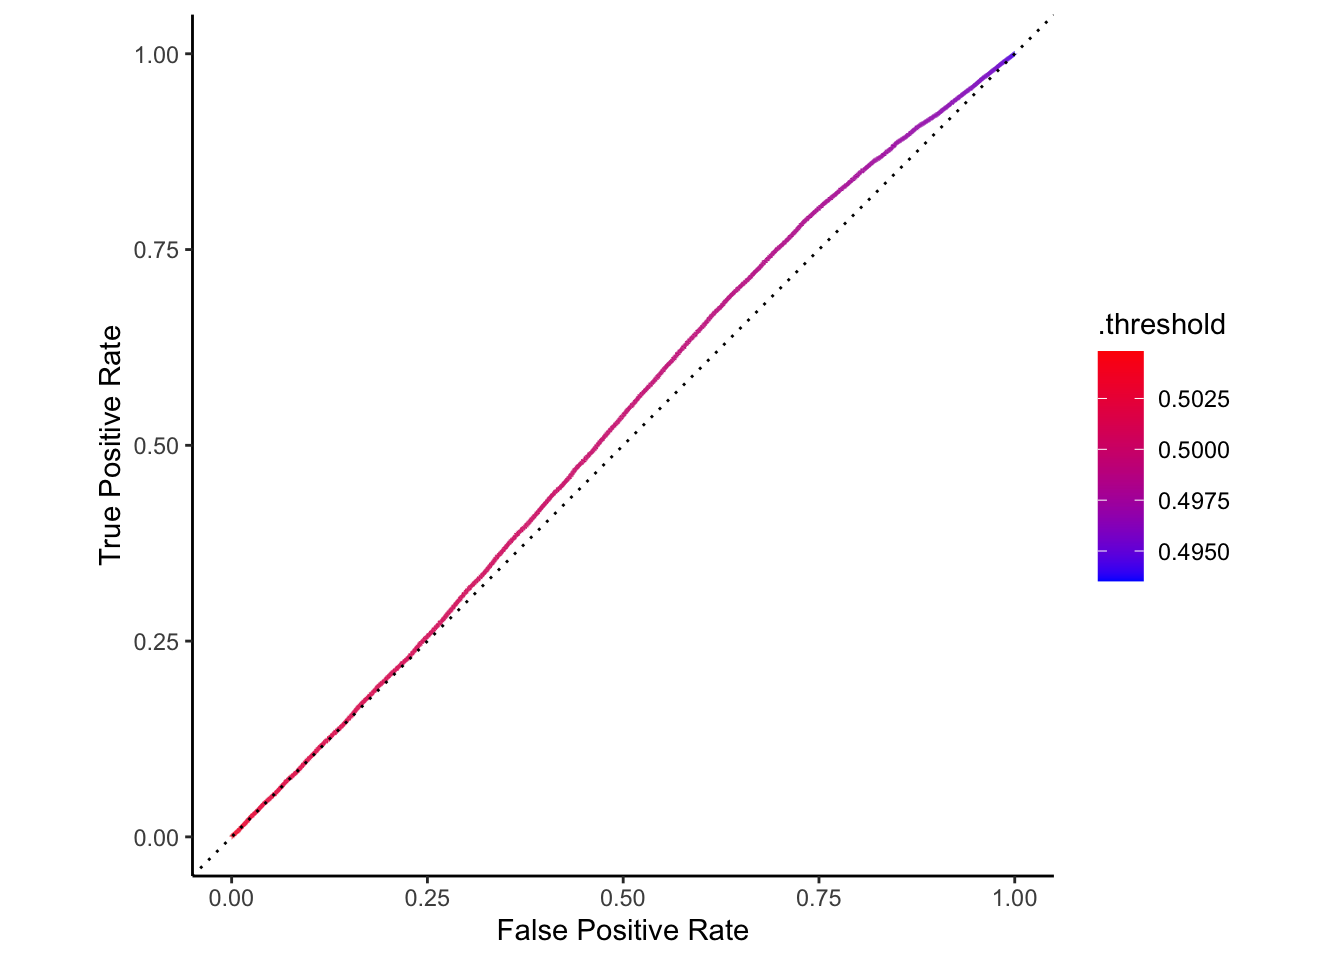

In [ ]:

probs |> 
  roc_curve(prob_raw, truth = label) |> 
  mutate(tp = round(sensitivity, 4),
         fp = round(1 - specificity, 4)) |>
  group_by(tp, fp) |> 
  summarise(.threshold = mean(.threshold)) |> 
  ggplot(aes(x = fp, y = tp, color = .threshold)) +
  geom_path(linewidth = 1) +
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "False Positive Rate",
       y = "True Positive Rate") +
  scale_x_continuous(breaks = seq(0,1,.25)) +
  scale_color_gradient(low="blue", high = "red")


In [ ]:
if (file.exists(here::here("_csv/aurocs.csv"))){
  aurocs <- read_csv(here("_csv/aurocs.csv"))
} else{
  aurocs <- probs |> 
    group_by(inner_split_num, outer_split_num) |> 
    summarize(auroc = roc_auc_vec(truth = label, estimate = prob_raw))
  
  aurocs |> write_csv(here("_csv/aurocs.csv"))
}


Rows: 300 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): inner_split_num, outer_split_num, auroc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

histogram of aurocs

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

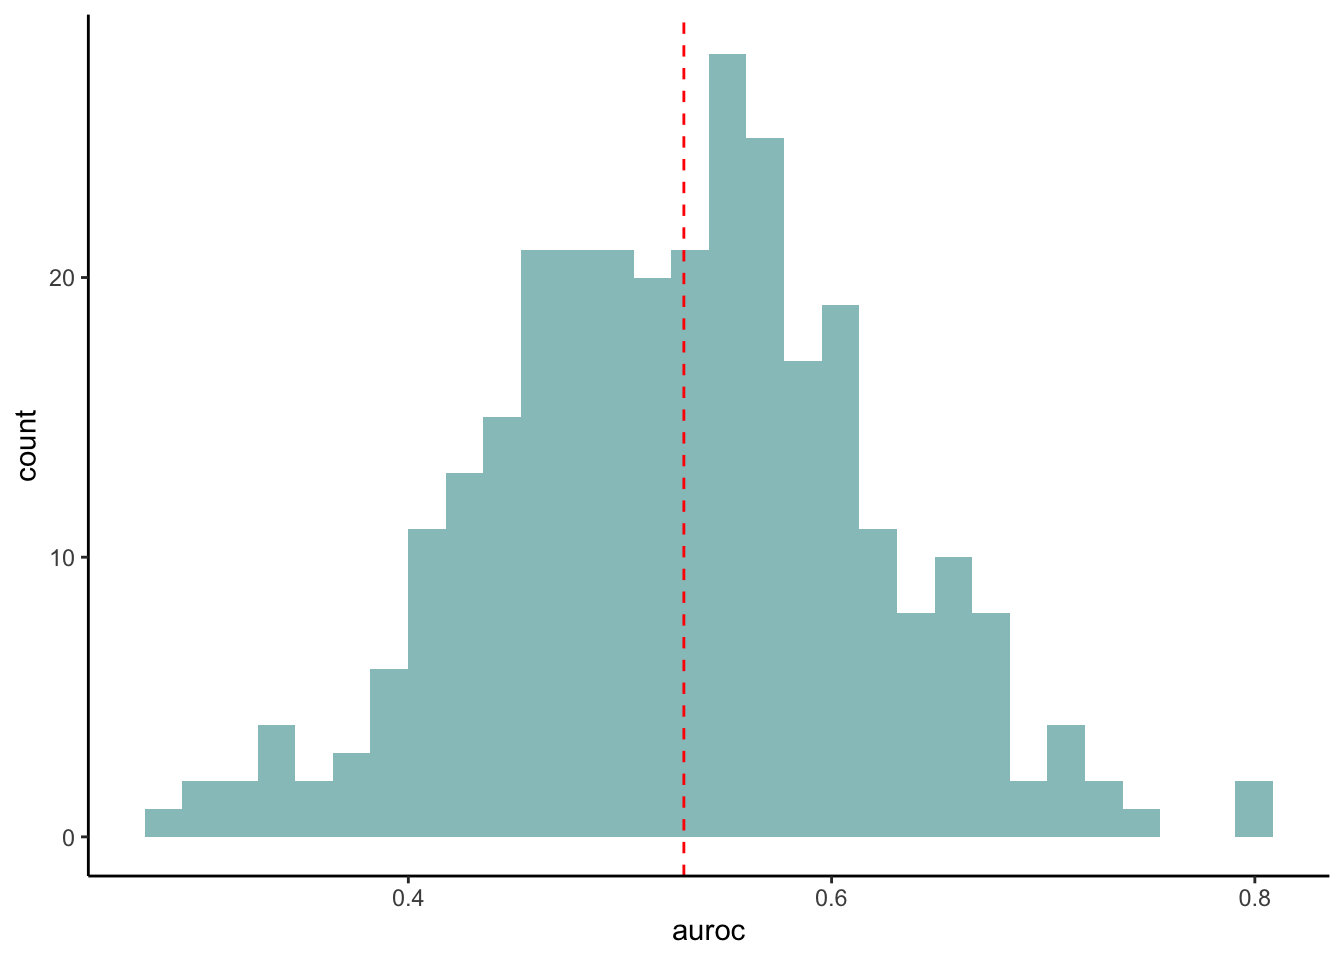

In [ ]:

aurocs |> 
  ggplot(aes(x = auroc)) +
  geom_histogram(fill = "#97C4C5") +
  geom_vline(xintercept = median(aurocs$auroc), linetype = "dashed", color = "red")


## Posterior Distribution

In [ ]:
if (file.exists(here(path_messages, "pp", "pp_auroc.rds"))){
  pp <- read_rds(here(path_messages, "pp", "pp_auroc.rds"))
} else{
  pp <- auroc |> 
    select(outer_split_num, inner_split_num, auroc) |> 
    rename(id = outer_split_num,
           id2 = inner_split_num) |> 
    perf_mod(formula = statistic ~ 1 + (1 | id/id2),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             # transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             iter = 13000, chains = 4,
             adapt_delta = .99999999,
             # cores = 4, seed = 12345,
             family = gaussian)
  
  pp |> 
    write_rds(here(path_messages, "pp", "pp_auroc.rds"))
}


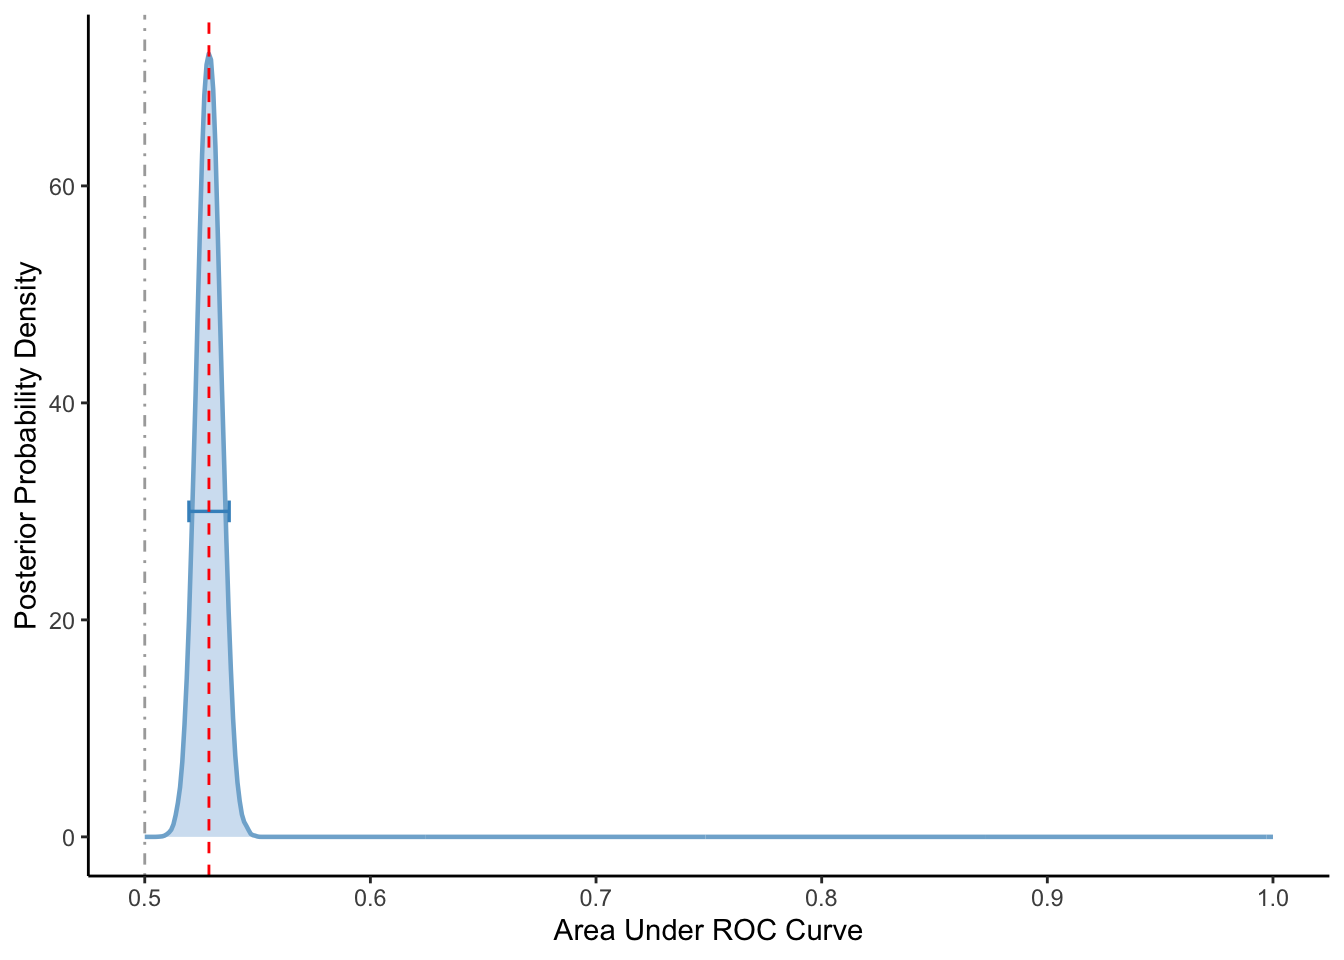

In [ ]:

pp_tidy <- pp |> 
  tidy(seed = 123)

ci <- pp_tidy |> 
  summary() |> 
  mutate(y = 30)

# vertical line for the median
pp_tidy |> 
  ggplot() + 
  geom_density(aes(x = posterior), color = c("#80B1D3"), 
               fill = c("#B3CFE8"), linewidth = .8, alpha = .6) +
  geom_errorbar(data = ci, aes(y = y, xmin = lower, xmax = upper), 
                linewidth = .6, width = 2, color = c("#4292C6")) +
  geom_vline(xintercept = median(pp_tidy$posterior), 
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = .5, 
             linetype = "dotdash", color = "darkgray") +
  ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve") +
  xlim(.5, 1)
